In [160]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
import statsmodels.api as sm
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

import pandas as pd
import time

import pickle
import joblib

# Modeling
---
1. Dataset preprocessing
2. Model Pipeline & params
3. 결과 확인
4. 추가 데이터 predict

### 1. Data preprocessing
---
- 범주형 데이터 처리
    - status: Developed, Developing
- GDP per capita 추가
- 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거

In [161]:
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

# 컬럼 추가
def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]
    return original

In [162]:
def preprocessing(data):
    # GDP per capita 데이터 추가
    data = add_feature(data, "gdppercap")

    # Nan값 GDP/POP으로 대체
    data["GDPPERCAP"].fillna(data["GDP"] / data["POPULATION"], inplace=True)
    data.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if 'STATUS' in data.columns.tolist():
        data = pd.get_dummies(original, columns=['STATUS'], drop_first=True)   
    
    return data

In [163]:
# corr
def get_top_features(data, drop_n=None):
    if drop_n is None:
        drop_n = len(data.columns)
        
    # LIFE_EXPECTANCY와 대한 나머지 feature들의 상관관계
    corr_matrix = data.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
    corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False) 
    
    # LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
    top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:drop_n]
    top_features = top_corr.index.tolist()
    
    return top_features

In [164]:
# lower fence, upper fence
def get_fence(data, top_features):
    region = data['REGION'].unique().tolist()
    fence = {}

    for r in region:
        fence[r] = {}

        for i, f in enumerate(top_features):
            q1 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 25)
            q3 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 75)
            iqr = q3 - q1

            upper_fence = ((iqr * 1.5) + q3).round(3)
            lower_fence = (q1 - (iqr * 1.5)).round(3)

            fence[r][f] = [lower_fence, upper_fence]
    
    return fence

In [165]:
# outlier processing
def drop_outlier(data, fence, top_features):
    region = data['REGION'].unique().tolist()
    drop_list, target_idx = [], []

    for r in region:
        target_df = data[data['REGION'] == r]

        for f in top_features:
            drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                                 (target_df[f] > fence[r][f][1])].index.tolist()

            drop_list.append(drop_idx)

    # 제거 대상 인덱스
    target_idx = set([idx for lst in drop_list for idx in lst])
    data = data.drop(target_idx, axis=0)
    
    return data

In [219]:
# 데이터 전처리
data = preprocessing(original)
top_features = get_top_features(data, 5)
fence = get_fence(data, top_features)
prep_data = drop_outlier(data, fence, top_features)
prep_data.reset_index(inplace=True, drop=True)

### 2. Pipeline & Params
---
- Linear Regression
- Decison Tree Regressor
- PCA + Linear Regression
- PLS Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Random Forest Regressor
- Support Vector Regressor
- Lasso
- Ridge
- Kernel Ridge Regression

In [167]:
def pipe_model():
    pipe_linear = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', LinearRegression())])
    pipe_tree = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', DTR())])
    pipe_lasso = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', Lasso(random_state=13))])
    pipe_ridge = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', Ridge(random_state=13))])
    pipe_pca = Pipeline([
                    ('scl', StandardScaler()),
                    ('pca', PCA()), 
                     ('fit',LinearRegression())])
    pipe_pls = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', PLS())])
    pipe_gbr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', GBR())])
    pipe_xgbr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', XGBR(random_state=13))])
    pipe_rfr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', RFR(random_state=13))])
    pipe_svr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', SVR())])
    pipe_KR = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', KernelRidge())])
    
    
    return [pipe_linear, pipe_tree, pipe_lasso, pipe_ridge, pipe_pca, pipe_pls, 
            pipe_gbr, pipe_xgbr, pipe_rfr, pipe_svr, pipe_KR]

In [168]:
def grid_params(max_depth, split_range):
    max_depth = max_depth
    min_samples_split_range = split_range
    
    grid_params_linear = [{
        "poly__degree": np.arange(1,3), 
        "fit__fit_intercept": [True, False] 
    }]
    grid_params_tree = [{
        
    }]
    grid_params_lasso = [{
        "poly__degree": np.arange(1,3),
        "fit__tol": np.logspace(-5,0,10),
        "fit__alpha": np.logspace(-5,1,10)
    }]
    grid_params_ridge = [{
        "poly__degree": np.arange(1,3),
        "fit__alpha": np.linspace(2,5,10),
        "fit__solver": [ "cholesky","lsqr","sparse_cg"],
        "fit__tol": np.logspace(-5,0,10)
    }]
    grid_params_pca = [{
        "pca__n_components": np.arange(2,8)
    }]
    grid_params_pls = [{
        "fit__n_components": np.arange(2,8)
    }]
    grid_params_gbr = [{
        "fit__max_features": ["sqrt","log2"],
        "fit__loss": ["ls","lad","huber","quantile"], 
        "fit__max_depth": max_depth,
        "fit__min_samples_split": min_samples_split_range
    }]
    grid_params_xgbr = [{
        "fit__max_features": ["sqrt","log2"] ,
        "fit__loss": ["ls","lad","huber","quantile"], 
        "fit__max_depth": max_depth,
        "fit__min_samples_split": min_samples_split_range
    }]
    grid_params_rfr = [{

    }]
    grid_params_svr = [{
        "fit__kernel": ["rbf", "linear"],
        "fit__degree": [2, 3, 5], 
        "fit__gamma": np.logspace(-5,1,10)
    }]
    grid_params_KR = [{
        "fit__kernel": ["rbf","linear"], 
        "fit__gamma": np.logspace(-5,1,10)
    }]

    
    return [grid_params_linear, grid_params_tree, grid_params_lasso, grid_params_ridge, grid_params_pca,
           grid_params_pls, grid_params_gbr, grid_params_xgbr, grid_params_rfr, grid_params_svr, grid_params_KR]

In [169]:
def grid_cv(pipe, params):
    jobs = -1
    cv = KFold(n_splits=5 , shuffle=True, random_state=13)

    grid_dict = {
        0: 'Linear Regression', 
        1: 'Decison Tree Regressor',
        2: 'Lasso',
        3: 'Ridge',
        4: 'PCA Regression', 
        5: 'PLS Regression',
        6: "Gradient Boosting Regressor",
        7: "XGBoost Regressor",
        8: "Random Forest Regressor",
        9: "Support Vector Regressor",
        10: "Kernel Ridge Regression"
                }
    
    return jobs, cv, grid_dict

### Model Fit
---
- GridSearchCV
- 결과 시각화

In [170]:
X = prep_data.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
y = prep_data['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=13)

#### GridSerachCV로 modeling 및 model save

In [172]:
def model_save(pipe, params, jobs, cv, grid_dict):
    model_rmse, model_r2, model_best_params, model_fit_times, model_res = {}, {}, {}, {}, {}

    for idx , (param, model) in enumerate(zip(params , pipe)):
        start_time = time.time()

        search = GridSearchCV(model, param, scoring="neg_mean_squared_error", 
                              cv=cv, n_jobs=jobs, verbose=-1)
        search.fit(X_train , y_train)

        y_pred = search.predict(X_test)

        model_rmse[grid_dict.get(idx)] = np.sqrt(mse(y_test, y_pred))  
        model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)  
        model_best_params[grid_dict.get(idx)] = search.best_params_
        model_fit_times[grid_dict.get(idx)] = time.time() - start_time
            
        joblib.dump(search, f'../models/{grid_dict.get(idx)}.pkl')
    
    print("finish")
        
    return model_rmse, model_r2, model_best_params, model_fit_times 

In [190]:
# Modeling 결과 (시각화)
def model_res_barchart(res_df):
    fig ,ax = plt.subplots(figsize=(20, 10))
    sns.set(font_scale = 2)
    ax = sns.barplot(y="Model", x="R2", data=res_df)
    
    return plt.show()

In [192]:
# Modeling 결과 (데이터프레임)
def model_res_df(model_r2, model_rmse, model_fit_times):
    output = pd.DataFrame([model_r2.keys() , model_r2.values(), model_rmse.values(), model_fit_times.values()], index = ["Model","R2", "RMSE", "Fit_times"]).T
    output.sort_values(["R2"], ascending= False ,inplace=True)
    output['R2'] = [float(_) for _ in output['R2']]
    output['RMSE'] = [float(_) for _ in output['RMSE']]
    
    return output

In [174]:
split_range = [0.5, 0.7, 0.9]
max_depth = [2, 4, 6, 8]

pipe = pipe_model()
params = grid_params(max_depth, split_range)
jobs, cv, grid_dict = grid_cv(pipe, params)

# Model().get_params().keys()로 가능한 params 조회 가능
model_rmse, model_r2, model_best_params, mpdel_fit_times = model_save(pipe, params, jobs, cv, grid_dict)

[15:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { loss, max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


finish


#### Modeling results

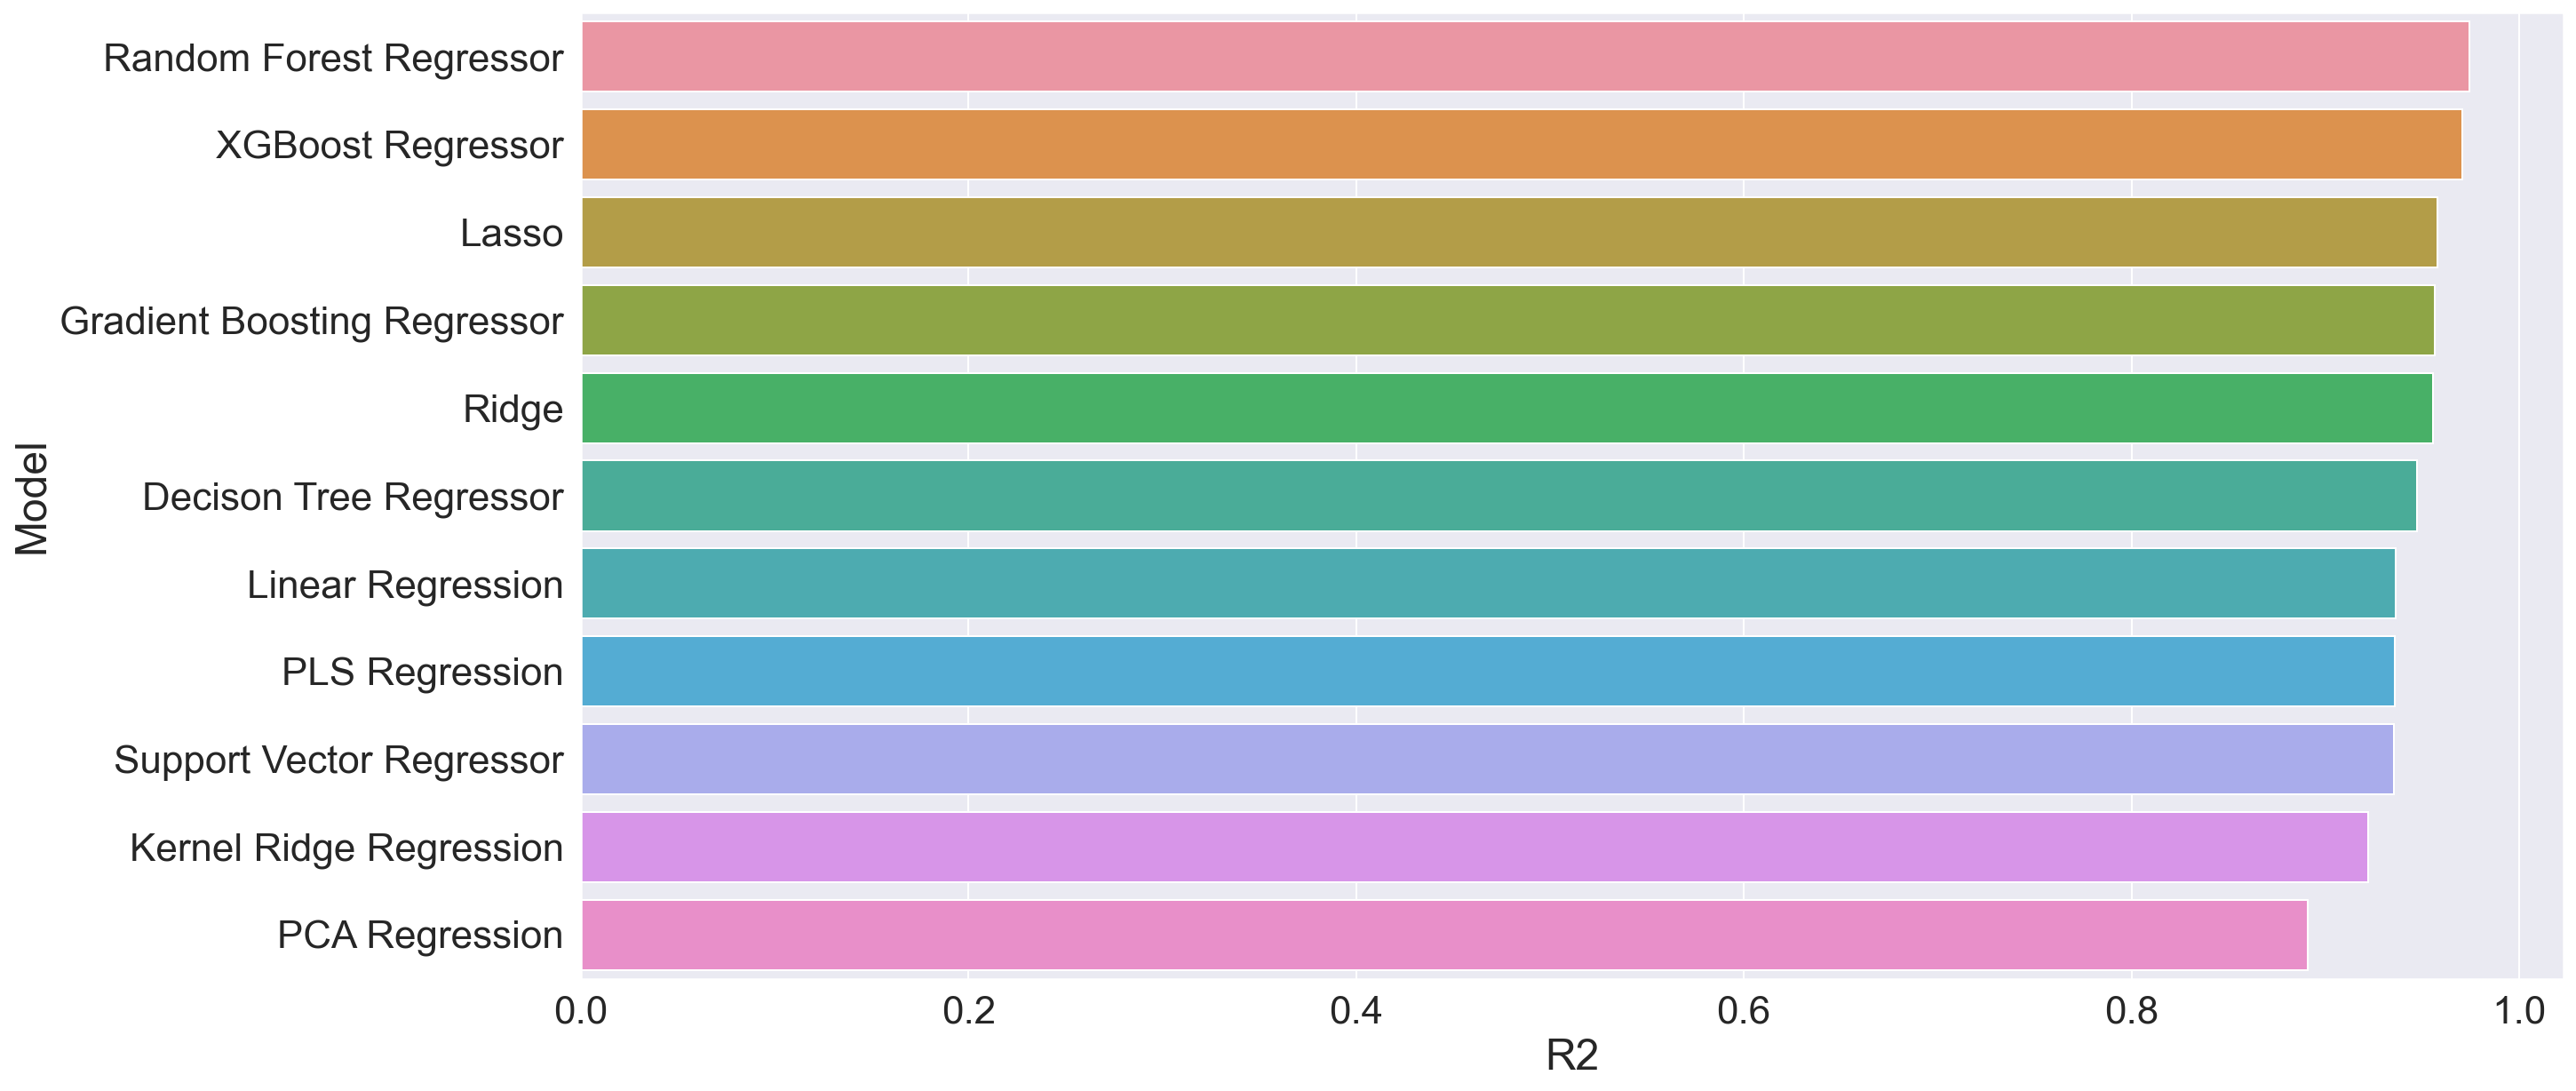

In [196]:
res_df = model_res_df(model_r2, model_rmse, model_fit_times) # 모델링 결과 데이터프레임
model_res_barchart(res_df) # 모델링 결과 시각화

In [184]:
px.scatter(output,x='RMSE', y='R2', color='Model', labels='Model')

### 4. 추가 Predict
--- 

#### 2019년 한국 데이터

In [198]:
# 2019년 한국 데이터셋
def set_testset():
    testset = pd.DataFrame(columns=original.columns)
    new_dict = {'COUNTRYCODE': 'KOR',
                'YEAR':2019, 'STATUS_Developing': 0,
                'LIFE_EXPECTANCY':83,
                'GDP': 1646739.22, 
                'GDPPERCAP':31846.2, 
                'SCHOOLING':14, 
                'INFANT_DEATHS':3,
                'ADULT_MORTALITY':110,
                'INCOME_COMPOSITION_OF_RESOURCES':0.916,
                'POPULATION': 51709000,
               }
    testset = testset.append(new_dict, ignore_index=True)
    testset.fillna(original.mean(), inplace=True)
    
    return testset

In [201]:
# 저장한 모델을 불러와 predict하는 함수
def model_predict(model_idx, test_df):
    saved_model = joblib.load(f"../models/{grid_dict.get(model_idx)}.pkl")
    
    X_pr = test_df[X.columns]
    y_pr = test_df['LIFE_EXPECTANCY']
    y_pred = saved_model.predict(X_pr)
    
    r2_score = r2(y_pr, y_pred)
    
    print(f"{grid_dict.get(model_idx)} | 예측 기대 수명:{y_pred.mean().round(2)} / RMSE:, {np.sqrt(mse(y_pr, y_pred)).round(2)}")
    
    if r2_score is True:
        print("R2:", r2_score)

In [214]:
# 추가 데이터 예측 결과
def extra_predict(extra_df):

    for idx, model_idx in enumerate(range(len(grid_dict))):
        model_predict(model_idx, extra_df)     

In [215]:
kor_df = set_testset()
extra_predict(kor_df)

Linear Regression | 예측 기대 수명:81.34 / RMSE:, 1.66
Decison Tree Regressor | 예측 기대 수명:76.9 / RMSE:, 6.1
Lasso | 예측 기대 수명:79.99 / RMSE:, 3.01
Ridge | 예측 기대 수명:78.82 / RMSE:, 4.18
PCA Regression | 예측 기대 수명:77.01 / RMSE:, 5.99
PLS Regression | 예측 기대 수명:80.91 / RMSE:, 2.09
Gradient Boosting Regressor | 예측 기대 수명:70.15 / RMSE:, 12.85
XGBoost Regressor | 예측 기대 수명:81.20999908447266 / RMSE:, 1.79
Random Forest Regressor | 예측 기대 수명:78.47 / RMSE:, 4.53
Support Vector Regressor | 예측 기대 수명:80.62 / RMSE:, 2.38
Kernel Ridge Regression | 예측 기대 수명:83.43 / RMSE:, 0.43


### 5. Model results visualization
----

In [204]:

data_df = pd.concat([prep_data[X.columns], prep_data['LIFE_EXPECTANCY']], axis=1)

X = data_df[X.columns]
y = data_df['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

data_df['split'] = 'train'
data_df.loc[X_test.index, 'split'] = 'test'

In [216]:
# reg plot 함수
def reg_plotly(model_idx):
    model = joblib.load(f"../models/{grid_dict.get(model_idx)}.pkl")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X)
    data_df['prediction'], data_df['y_test'], data_df['y_train'] = y_pred, y_test, y_pred

    fig = px.scatter(
            data_df, x=data_df['LIFE_EXPECTANCY'], y=data_df['prediction'],
            marginal_y='histogram', color='split', title=f"{grid_dict.get(model_idx)} Model", 
            color_discrete_sequence=['red', 'cornflowerblue'])

    fig.update_traces(histnorm='probability', selector={'type': 'histogram'})

    fig.add_shape(type='line', line=dict(dash='dash'),
        x0=y.min(), y0=y.min(),
        x1=y.max(), y1=y.max()
    )
    
    fig.update_layout(font_size=14, width=1000, height=600, template='plotly_white')
    
    return fig.show()

In [217]:
reg_plotly(0)

In [218]:
reg_plotly(8)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
import statsmodels.api as sm
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

import pandas as pd
import time

import pickle
import joblib

# Modeling
---
1. Dataset preprocessing
2. Model Pipeline & params
3. 결과 확인
4. 추가 데이터 predict

### 1. Data preprocessing
---
- 범주형 데이터 처리
    - status: Developed, Developing
- GDP per capita 추가
- 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거

original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

# 컬럼 추가
def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]
    return original

def preprocessing(data):
    # GDP per capita 데이터 추가
    data = add_feature(data, "gdppercap")

    # Nan값 GDP/POP으로 대체
    data["GDPPERCAP"].fillna(data["GDP"] / data["POPULATION"], inplace=True)
    data.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if 'STATUS' in data.columns.tolist():
        data = pd.get_dummies(original, columns=['STATUS'], drop_first=True)   
    
    return data

# corr
def get_top_features(data, drop_n=None):
    if drop_n is None:
        drop_n = len(data.columns)
        
    # LIFE_EXPECTANCY와 대한 나머지 feature들의 상관관계
    corr_matrix = data.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
    corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False) 
    
    # LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
    top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:drop_n]
    top_features = top_corr.index.tolist()
    
    return top_features

# lower fence, upper fence
def get_fence(data, top_features):
    region = data['REGION'].unique().tolist()
    fence = {}

    for r in region:
        fence[r] = {}

        for i, f in enumerate(top_features):
            q1 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 25)
            q3 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 75)
            iqr = q3 - q1

            upper_fence = ((iqr * 1.5) + q3).round(3)
            lower_fence = (q1 - (iqr * 1.5)).round(3)

            fence[r][f] = [lower_fence, upper_fence]
    
    return fence

# outlier processing
def drop_outlier(data, fence, top_features):
    region = data['REGION'].unique().tolist()
    drop_list, target_idx = [], []

    for r in region:
        target_df = data[data['REGION'] == r]

        for f in top_features:
            drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                                 (target_df[f] > fence[r][f][1])].index.tolist()

            drop_list.append(drop_idx)

    # 제거 대상 인덱스
    target_idx = set([idx for lst in drop_list for idx in lst])
    data = data.drop(target_idx, axis=0)
    
    return data

# 데이터 전처리
data = preprocessing(original)
top_features = get_top_features(data, 5)
fence = get_fence(data, top_features)
prep_data = drop_outlier(data, fence, top_features)
prep_data.reset_index(inplace=True, drop=True)

### 2. Pipeline & Params
---
- Linear Regression
- Decison Tree Regressor
- PCA + Linear Regression
- PLS Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Random Forest Regressor
- Support Vector Regressor
- Lasso
- Ridge
- Kernel Ridge Regression

def pipe_model():
    pipe_linear = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', LinearRegression())])
    pipe_tree = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', DTR())])
    pipe_lasso = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', Lasso(random_state=13))])
    pipe_ridge = Pipeline([
                    ('scl', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                     ('fit', Ridge(random_state=13))])
    pipe_pca = Pipeline([
                    ('scl', StandardScaler()),
                    ('pca', PCA()), 
                     ('fit',LinearRegression())])
    pipe_pls = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', PLS())])
    pipe_gbr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', GBR())])
    pipe_xgbr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', XGBR(random_state=13))])
    pipe_rfr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', RFR(random_state=13))])
    pipe_svr = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', SVR())])
    pipe_KR = Pipeline([
                    ('scl', StandardScaler()),
                     ('fit', KernelRidge())])
    
    
    return [pipe_linear, pipe_tree, pipe_lasso, pipe_ridge, pipe_pca, pipe_pls, 
            pipe_gbr, pipe_xgbr, pipe_rfr, pipe_svr, pipe_KR]

def grid_params(max_depth, split_range):
    max_depth = max_depth
    min_samples_split_range = split_range
    
    grid_params_linear = [{
        "poly__degree": np.arange(1,3), 
        "fit__fit_intercept": [True, False] 
    }]
    grid_params_tree = [{
        
    }]
    grid_params_lasso = [{
        "poly__degree": np.arange(1,3),
        "fit__tol": np.logspace(-5,0,10),
        "fit__alpha": np.logspace(-5,1,10)
    }]
    grid_params_ridge = [{
        "poly__degree": np.arange(1,3),
        "fit__alpha": np.linspace(2,5,10),
        "fit__solver": [ "cholesky","lsqr","sparse_cg"],
        "fit__tol": np.logspace(-5,0,10)
    }]
    grid_params_pca = [{
        "pca__n_components": np.arange(2,8)
    }]
    grid_params_pls = [{
        "fit__n_components": np.arange(2,8)
    }]
    grid_params_gbr = [{
        "fit__max_features": ["sqrt","log2"],
        "fit__loss": ["ls","lad","huber","quantile"], 
        "fit__max_depth": max_depth,
        "fit__min_samples_split": min_samples_split_range
    }]
    grid_params_xgbr = [{
        "fit__max_features": ["sqrt","log2"] ,
        "fit__loss": ["ls","lad","huber","quantile"], 
        "fit__max_depth": max_depth,
        "fit__min_samples_split": min_samples_split_range
    }]
    grid_params_rfr = [{

    }]
    grid_params_svr = [{
        "fit__kernel": ["rbf", "linear"],
        "fit__degree": [2, 3, 5], 
        "fit__gamma": np.logspace(-5,1,10)
    }]
    grid_params_KR = [{
        "fit__kernel": ["rbf","linear"], 
        "fit__gamma": np.logspace(-5,1,10)
    }]

    
    return [grid_params_linear, grid_params_tree, grid_params_lasso, grid_params_ridge, grid_params_pca,
           grid_params_pls, grid_params_gbr, grid_params_xgbr, grid_params_rfr, grid_params_svr, grid_params_KR]

def grid_cv(pipe, params):
    jobs = -1
    cv = KFold(n_splits=5 , shuffle=True, random_state=13)

    grid_dict = {
        0: 'Linear Regression', 
        1: 'Decison Tree Regressor',
        2: 'Lasso',
        3: 'Ridge',
        4: 'PCA Regression', 
        5: 'PLS Regression',
        6: "Gradient Boosting Regressor",
        7: "XGBoost Regressor",
        8: "Random Forest Regressor",
        9: "Support Vector Regressor",
        10: "Kernel Ridge Regression"
                }
    
    return jobs, cv, grid_dict

### Model Fit
---
- GridSearchCV
- 결과 시각화

X = prep_data.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
y = prep_data['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=13)

#### GridSerachCV로 modeling 및 model save

def model_save(pipe, params, jobs, cv, grid_dict):
    model_rmse, model_r2, model_best_params, model_fit_times, model_res = {}, {}, {}, {}, {}

    for idx , (param, model) in enumerate(zip(params , pipe)):
        start_time = time.time()

        search = GridSearchCV(model, param, scoring="neg_mean_squared_error", 
                              cv=cv, n_jobs=jobs, verbose=-1)
        search.fit(X_train , y_train)

        y_pred = search.predict(X_test)

        model_rmse[grid_dict.get(idx)] = np.sqrt(mse(y_test, y_pred))  
        model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)  
        model_best_params[grid_dict.get(idx)] = search.best_params_
        model_fit_times[grid_dict.get(idx)] = time.time() - start_time
            
        joblib.dump(search, f'../models/{grid_dict.get(idx)}.pkl')
    
    print("finish")
        
    return model_rmse, model_r2, model_best_params, model_fit_times 

# Modeling 결과 (시각화)
def model_res_barchart(res_df):
    fig ,ax = plt.subplots(figsize=(20, 10))
    sns.set(font_scale = 2)
    ax = sns.barplot(y="Model", x="R2", data=res_df)
    
    return plt.show()

# Modeling 결과 (데이터프레임)
def model_res_df(model_r2, model_rmse, model_fit_times):
    output = pd.DataFrame([model_r2.keys() , model_r2.values(), model_rmse.values(), model_fit_times.values()], index = ["Model","R2", "RMSE", "Fit_times"]).T
    output.sort_values(["R2"], ascending= False ,inplace=True)
    output['R2'] = [float(_) for _ in output['R2']]
    output['RMSE'] = [float(_) for _ in output['RMSE']]
    
    return output

split_range = [0.5, 0.7, 0.9]
max_depth = [2, 4, 6, 8]

pipe = pipe_model()
params = grid_params(max_depth, split_range)
jobs, cv, grid_dict = grid_cv(pipe, params)

# Model().get_params().keys()로 가능한 params 조회 가능
model_rmse, model_r2, model_best_params, mpdel_fit_times = model_save(pipe, params, jobs, cv, grid_dict)

#### Modeling results

res_df = model_res_df(model_r2, model_rmse, model_fit_times) # 모델링 결과 데이터프레임
model_res_barchart(res_df) # 모델링 결과 시각화

px.scatter(output,x='RMSE', y='R2', color='Model', labels='Model')

### 4. 추가 Predict
--- 

#### 2019년 한국 데이터

# 2019년 한국 데이터셋
def set_testset():
    testset = pd.DataFrame(columns=original.columns)
    new_dict = {'COUNTRYCODE': 'KOR',
                'YEAR':2019, 'STATUS_Developing': 0,
                'LIFE_EXPECTANCY':83,
                'GDP': 1646739.22, 
                'GDPPERCAP':31846.2, 
                'SCHOOLING':14, 
                'INFANT_DEATHS':3,
                'ADULT_MORTALITY':110,
                'INCOME_COMPOSITION_OF_RESOURCES':0.916,
                'POPULATION': 51709000,
               }
    testset = testset.append(new_dict, ignore_index=True)
    testset.fillna(original.mean(), inplace=True)
    
    return testset

# 저장한 모델을 불러와 predict하는 함수
def model_predict(model_idx, test_df):
    saved_model = joblib.load(f"../models/{grid_dict.get(model_idx)}.pkl")
    
    X_pr = test_df[X.columns]
    y_pr = test_df['LIFE_EXPECTANCY']
    y_pred = saved_model.predict(X_pr)
    
    r2_score = r2(y_pr, y_pred)
    
    print(f"{grid_dict.get(model_idx)} | 예측 기대 수명:{y_pred.mean().round(2)} / RMSE:, {np.sqrt(mse(y_pr, y_pred)).round(2)}")
    
    if r2_score is True:
        print("R2:", r2_score)

# 추가 데이터 예측 결과
def extra_predict(extra_df):

    for idx, model_idx in enumerate(range(len(grid_dict))):
        model_predict(model_idx, extra_df)     

kor_df = set_testset()
extra_predict(kor_df)

### 5. Model results visualization
----


data_df = pd.concat([prep_data[X.columns], prep_data['LIFE_EXPECTANCY']], axis=1)

X = data_df[X.columns]
y = data_df['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

data_df['split'] = 'train'
data_df.loc[X_test.index, 'split'] = 'test'

# reg plot 함수
def reg_plotly(model_idx):
    model = joblib.load(f"../models/{grid_dict.get(model_idx)}.pkl")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X)
    data_df['prediction'], data_df['y_test'], data_df['y_train'] = y_pred, y_test, y_pred

    fig = px.scatter(
            data_df, x=data_df['LIFE_EXPECTANCY'], y=data_df['prediction'],
            marginal_y='histogram', color='split', title=f"{grid_dict.get(model_idx)} Model", 
            color_discrete_sequence=['red', 'cornflowerblue'])

    fig.update_traces(histnorm='probability', selector={'type': 'histogram'})

    fig.add_shape(type='line', line=dict(dash='dash'),
        x0=y.min(), y0=y.min(),
        x1=y.max(), y1=y.max()
    )
    
    fig.update_layout(font_size=14, width=1000, height=600, template='plotly_white')
    
    return fig.show()

reg_plotly(0)

reg_plotly(8)